In [67]:
%load_ext autoreload
%autoreload 2
from models.diffusion import StableDiffusion
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image
from utils.model_converter import load_weights_from_ckpt


prompt = "A cat with glasses"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
input_image = None
image_path = "./images/cat.png"
input_image = Image.open(image_path).convert('RGB')

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.7

## SAMPLER
num_inference_steps = 50
seed = 42
model = StableDiffusion(model_type='txt2img')
loaded_state_dict = load_weights_from_ckpt('./weights/model/v1-5-pruned-emaonly.ckpt', device='cpu')
model.vae.load_state_dict(loaded_state_dict['vae'], strict=True)
model.unet.load_state_dict(loaded_state_dict['unet'], strict=True)
model.cond_encoder.load_state_dict(loaded_state_dict['cond_encoder'], strict=True)

tokenizer = CLIPTokenizer('./weights/tokenizer/tokenizer_vocab.json', merges_file='./weights/tokenizer/tokenizer_merges.txt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
%load_ext autoreload
%autoreload 2
output_image = model.generate(
    input_image=input_image,
    img_size=(512, 512),
     prompt=prompt,
     uncond_promt=uncond_prompt,
     do_cfg=do_cfg,
     cfg_scale=cfg_scale,
     device='mps',
     strength=strength,
     inference_steps=num_inference_steps,
     sampler='ddpm',
     use_cosine_schedule=False,
     seed=seed,
     tokenizer=tokenizer
)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████████████████████████| 35/35 [00:56<00:00,  1.62s/it]


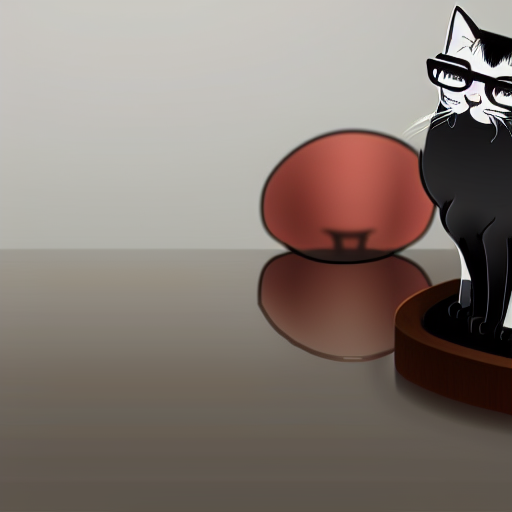

In [69]:
Image.fromarray(output_image)

In [ ]:
%load_ext autoreload
%autoreload 2
!PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 python3 train.py --device=mps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


python(7783) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  0%|                                                   | 0/300 [00:00<?, ?it/s]
0it [00:00, ?it/s]